* https://www.kaggle.com/ntnu-testimon/paysim1

In [1]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

In [2]:
# timing helper functions

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [3]:
# don't need this for scikit learn, just set njobs = ncores

# set up parallel cluster using ipyparallel engines.
# ipcluster start
#import ipyparallel as ipp
#from ipyparallel import require
#c = ipp.Client(profile='default')
#v = c[:]
##print("engines running:",v)
#print("engines running:",len(v))

In [4]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.6,C1231006815,170136.0,160296.4,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.3,C1666544295,21249.0,19384.7,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.1,C2048537720,41554.0,29885.9,M1230701703,0.0,0.0,0,0


In [6]:
data.shape

(6362620, 11)

Elapsed time is 1.011234998703003 seconds.


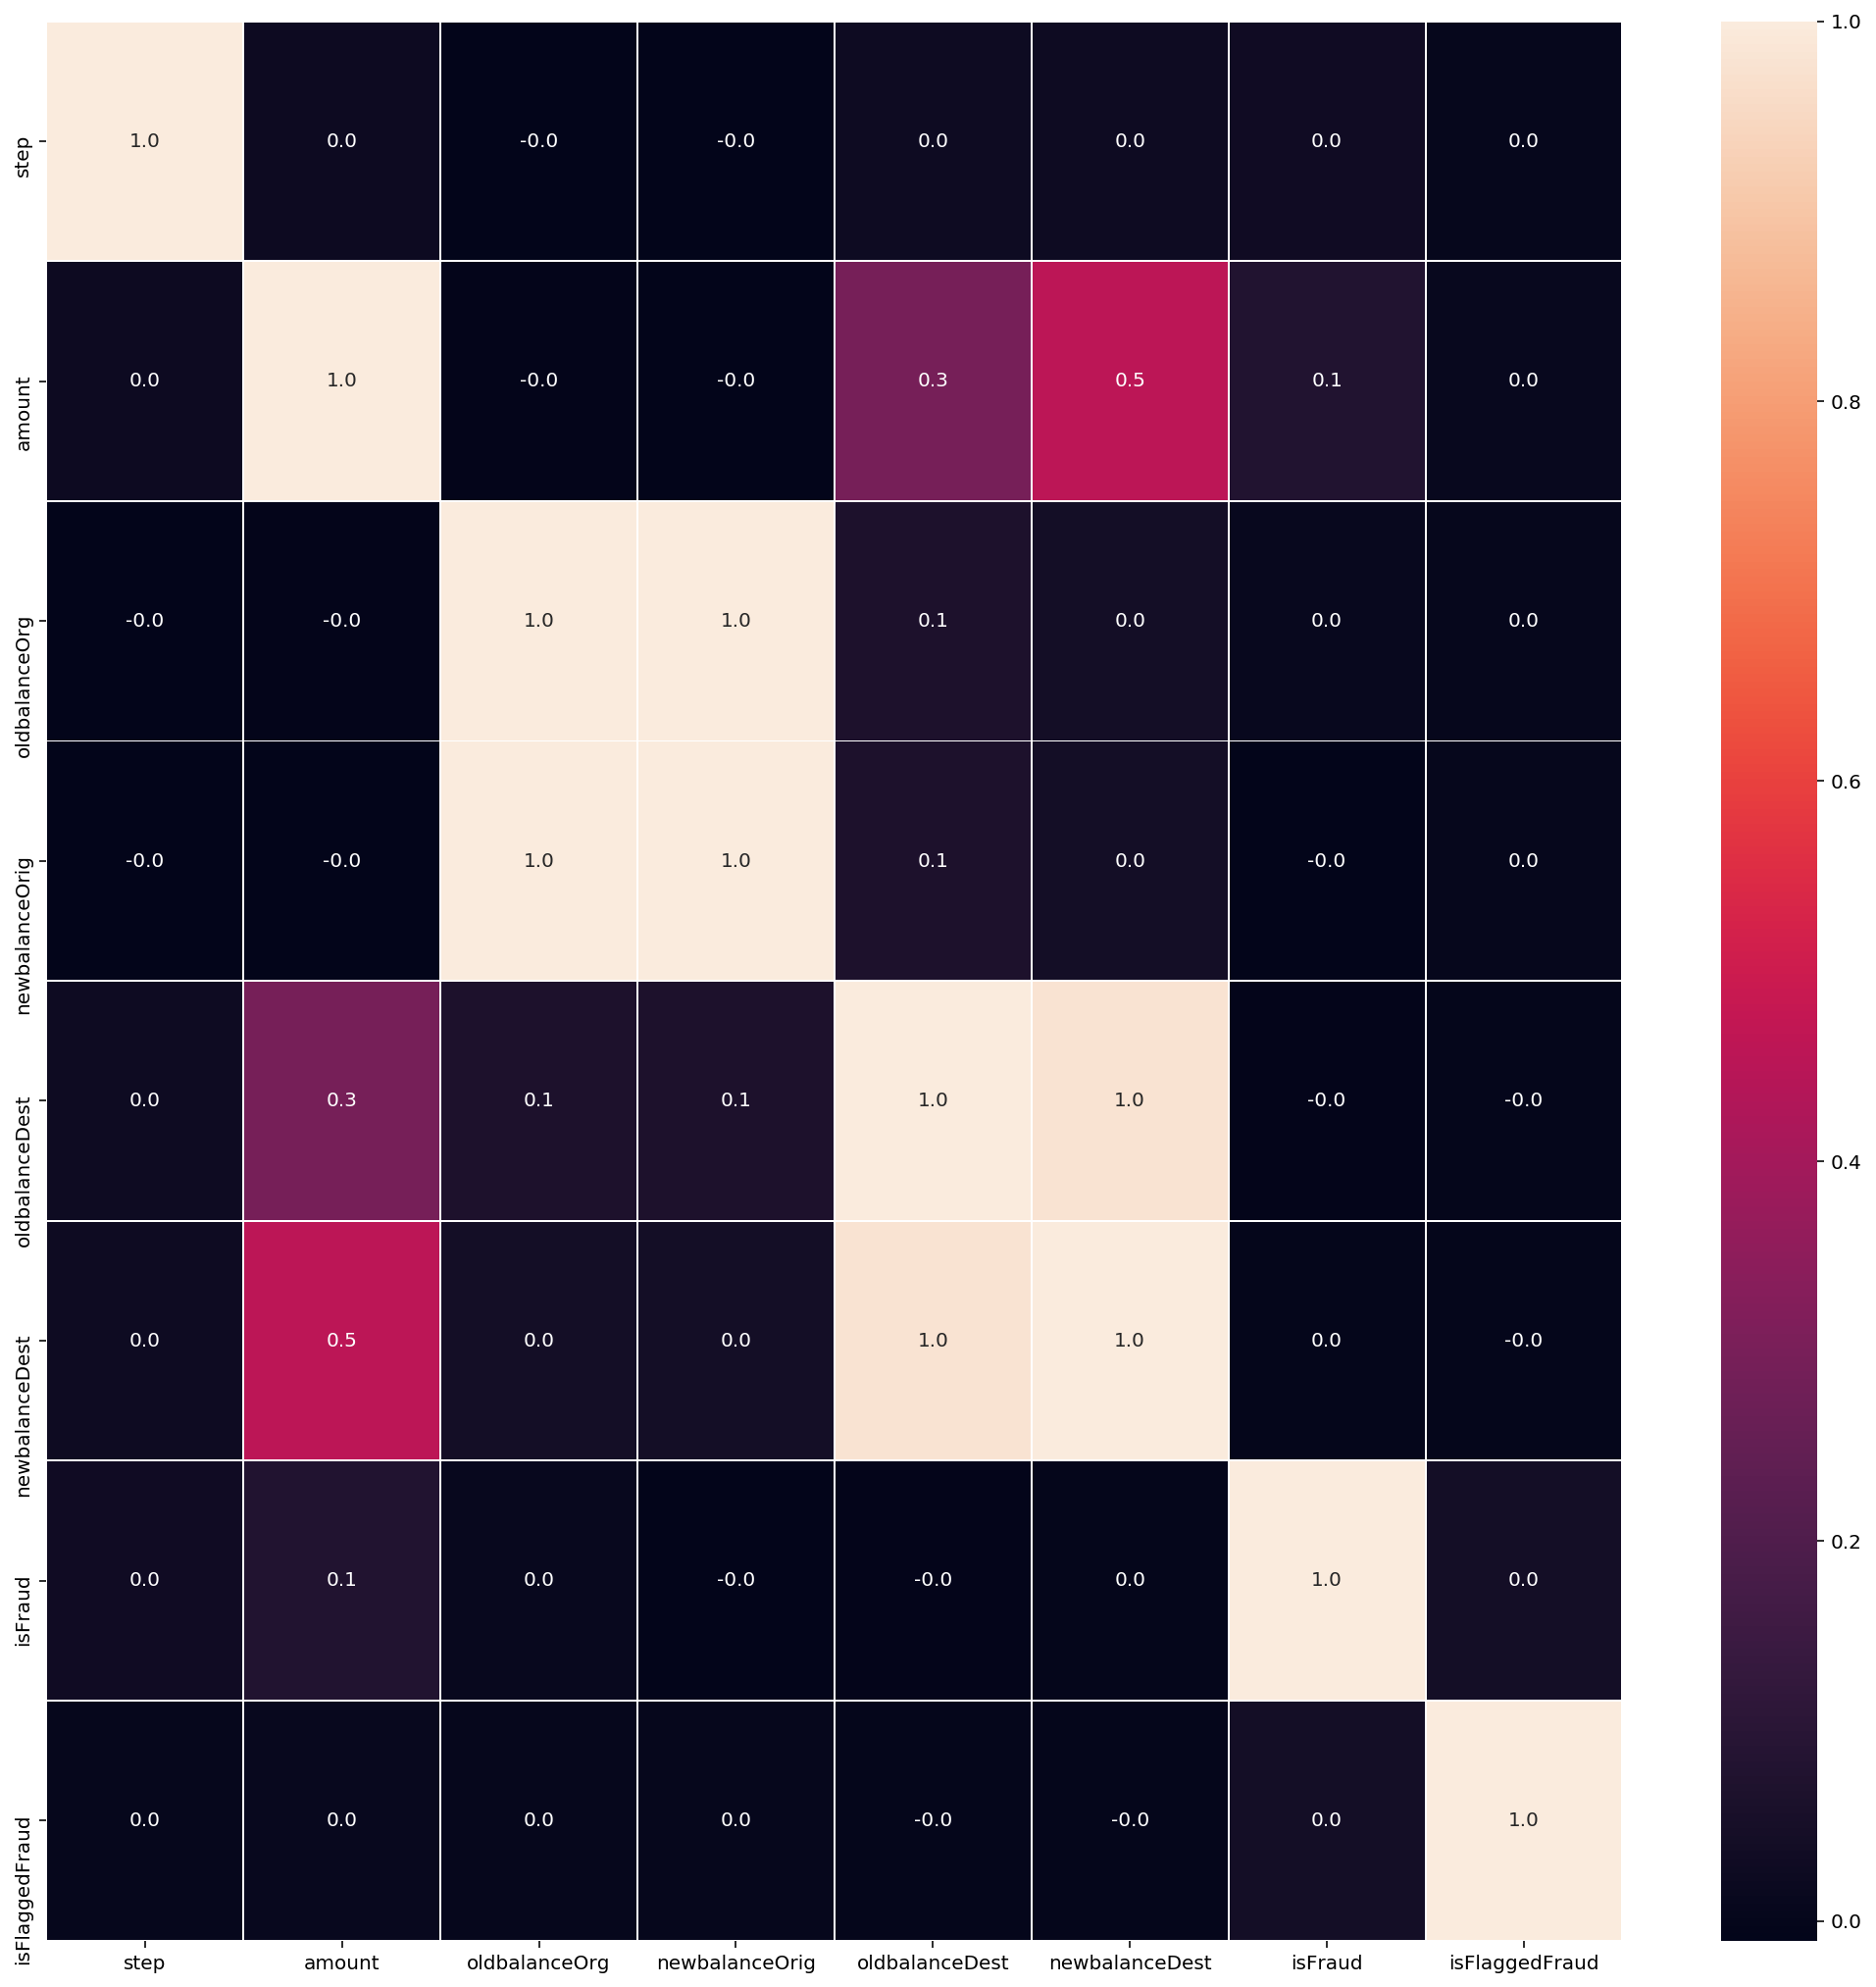

In [7]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

In [8]:
#look at class imbalance
by_class = data.groupby('isFraud')
by_class.describe()

amount                                                      \
            count      mean       std min      25%      50%       75%   
isFraud                                                                 
0       6354407.0  178197.0  596237.0 0.0  13368.4  74684.7  208364.8   
1          8213.0 1467967.3 2404252.9 0.0 127091.3 441423.4 1517771.5   

                   isFlaggedFraud       ...  oldbalanceOrg             \
               max          count mean  ...            75%        max   
isFraud                                 ...                             
0       92445516.6      6354407.0  0.0  ...       106969.5 43818855.3   
1       10000000.0         8213.0  0.0  ...      1517771.5 59585040.4   

             step                                          
            count  mean   std min   25%   50%   75%   max  
isFraud                                                    
0       6354407.0 243.2 142.1 1.0 156.0 239.0 334.0 718.0  
1          8213.0 368.4 216.4 1.0 181.0 367.0 558.0 743.0  

[2 rows x 56 columns]

In [9]:
#look at class imbalance
by_class = data.groupby('isFlaggedFraud')
by_class.describe()

amount                                                   \
                   count      mean       std      min       25%       50%   
isFlaggedFraud                                                              
0              6362604.0  179850.1  603788.4      0.0   13389.5   74871.3   
1                   16.0 4861597.7 3572499.1 353874.2 2242748.7 4234245.1   

                                      isFraud       ...  oldbalanceOrg  \
                     75%        max     count mean  ...            75%   
isFlaggedFraud                                      ...                  
0               208720.5 92445516.6 6362604.0  0.0  ...       107314.0   
1              7883451.4 10000000.0      16.0  1.0  ...     12128347.6   

                               step                                            
                      max     count  mean   std   min   25%   50%   75%   max  
isFlaggedFraud                                                                 
0              59585040.4 6362604.0 243.4 142.3   1.0 156.0 239.0 335.0 743.0  
1              19585040.4      16.0 537.6 181.9 212.0 415.5 601.5 678.8 741.0  

[2 rows x 56 columns]

In [10]:
data.groupby('type')['isFraud','isFlaggedFraud'].sum()

,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


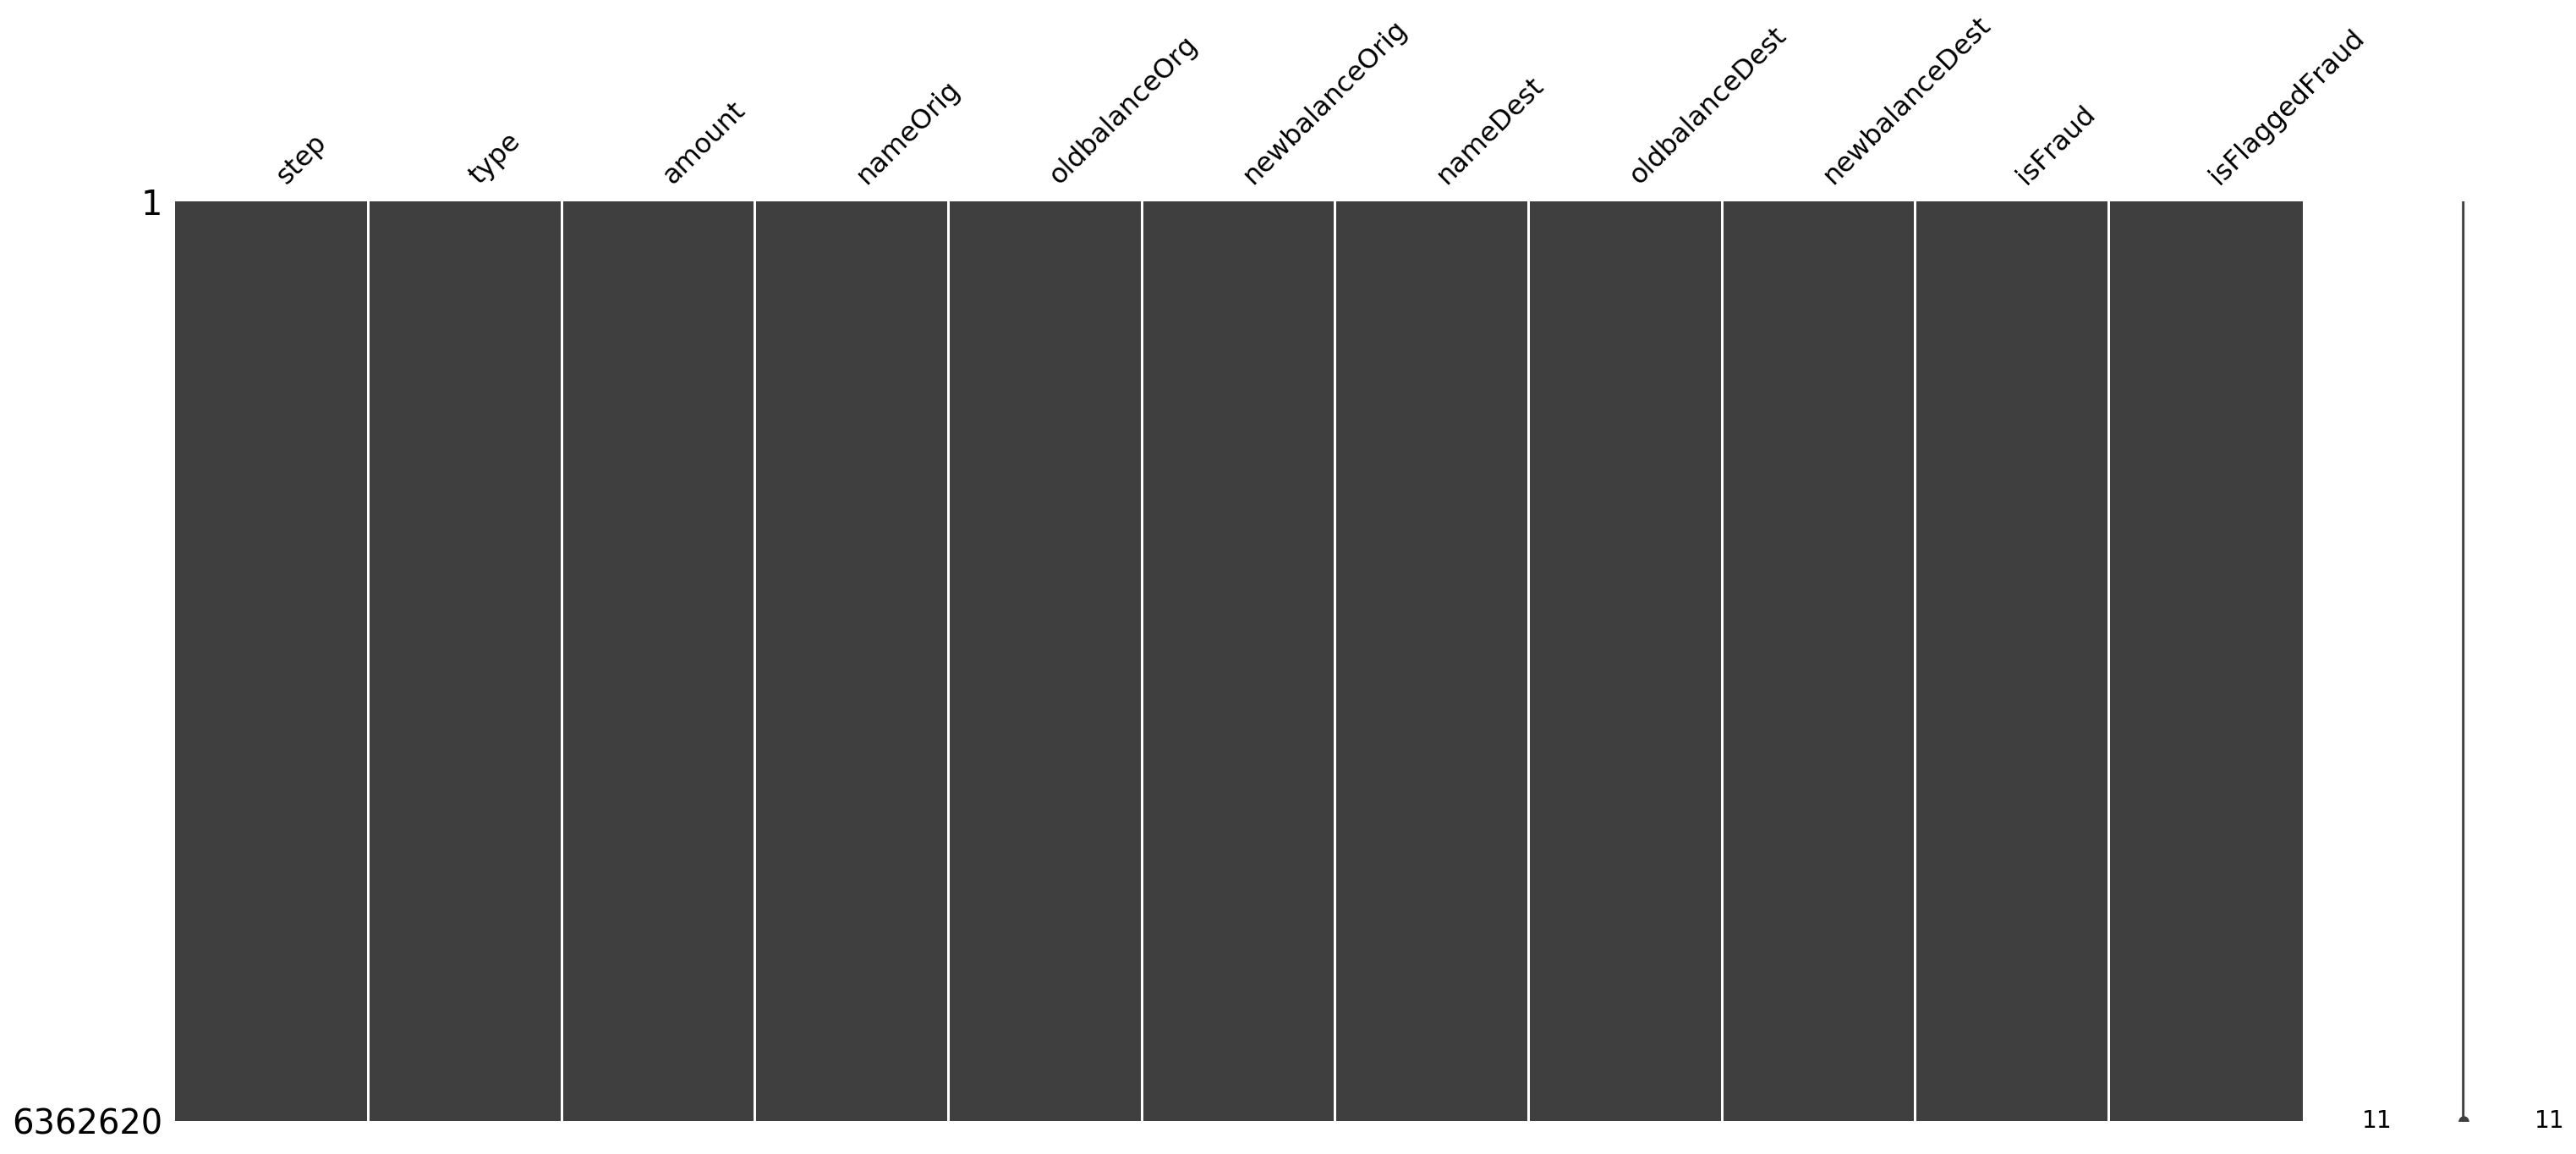

In [11]:
msno.matrix(data); # looks like no missing values

### Normalise the data

In [12]:
norm_step = np.array(data['step'])
norm_amount = np.array(data['amount'])
norm_newbalanceOrig = np.array(data['newbalanceOrig'])
norm_newbalanceDest = np.array(data['newbalanceDest'])

norm_step = StandardScaler().fit_transform(norm_step.reshape(-1,1))
norm_amount = StandardScaler().fit_transform(norm_step.reshape(-1,1))
norm_newbalanceOrig = StandardScaler().fit_transform(norm_newbalanceOrig.reshape(-1,1))
norm_newbalanceDest = StandardScaler().fit_transform(norm_newbalanceDest.reshape(-1,1))

/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
data['norm_step'] = norm_step
data['norm_amount'] = norm_amount
data['norm_newbalanceOrig'] = norm_newbalanceOrig
data['norm_newbalanceDest'] = norm_newbalanceDest

In [14]:
# encode the transaction type
# http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
cols_to_transform = ['type']
type_hash = pd.get_dummies(data=data['type'])
#data['type_hash'] = type_hash

In [15]:
data = pd.concat([data, type_hash], axis=1)

del data['step']
del data['amount']
del data['newbalanceOrig']
del data['newbalanceDest']
del data['nameOrig']
del data['nameDest']
del data['type']

In [16]:
data.head(10)

,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,norm_step,norm_amount,norm_newbalanceOrig,norm_newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,170136.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
1,21249.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
2,181.0,0.0,1,0,-1.7,-1.7,-0.3,-0.3,0,0,0,0,1
3,181.0,21182.0,1,0,-1.7,-1.7,-0.3,-0.3,0,1,0,0,0
4,41554.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
5,53860.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
6,183195.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
7,176087.2,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
8,2671.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
9,41720.0,41898.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,1,0,0


Elapsed time is 2.6054508686065674 seconds.


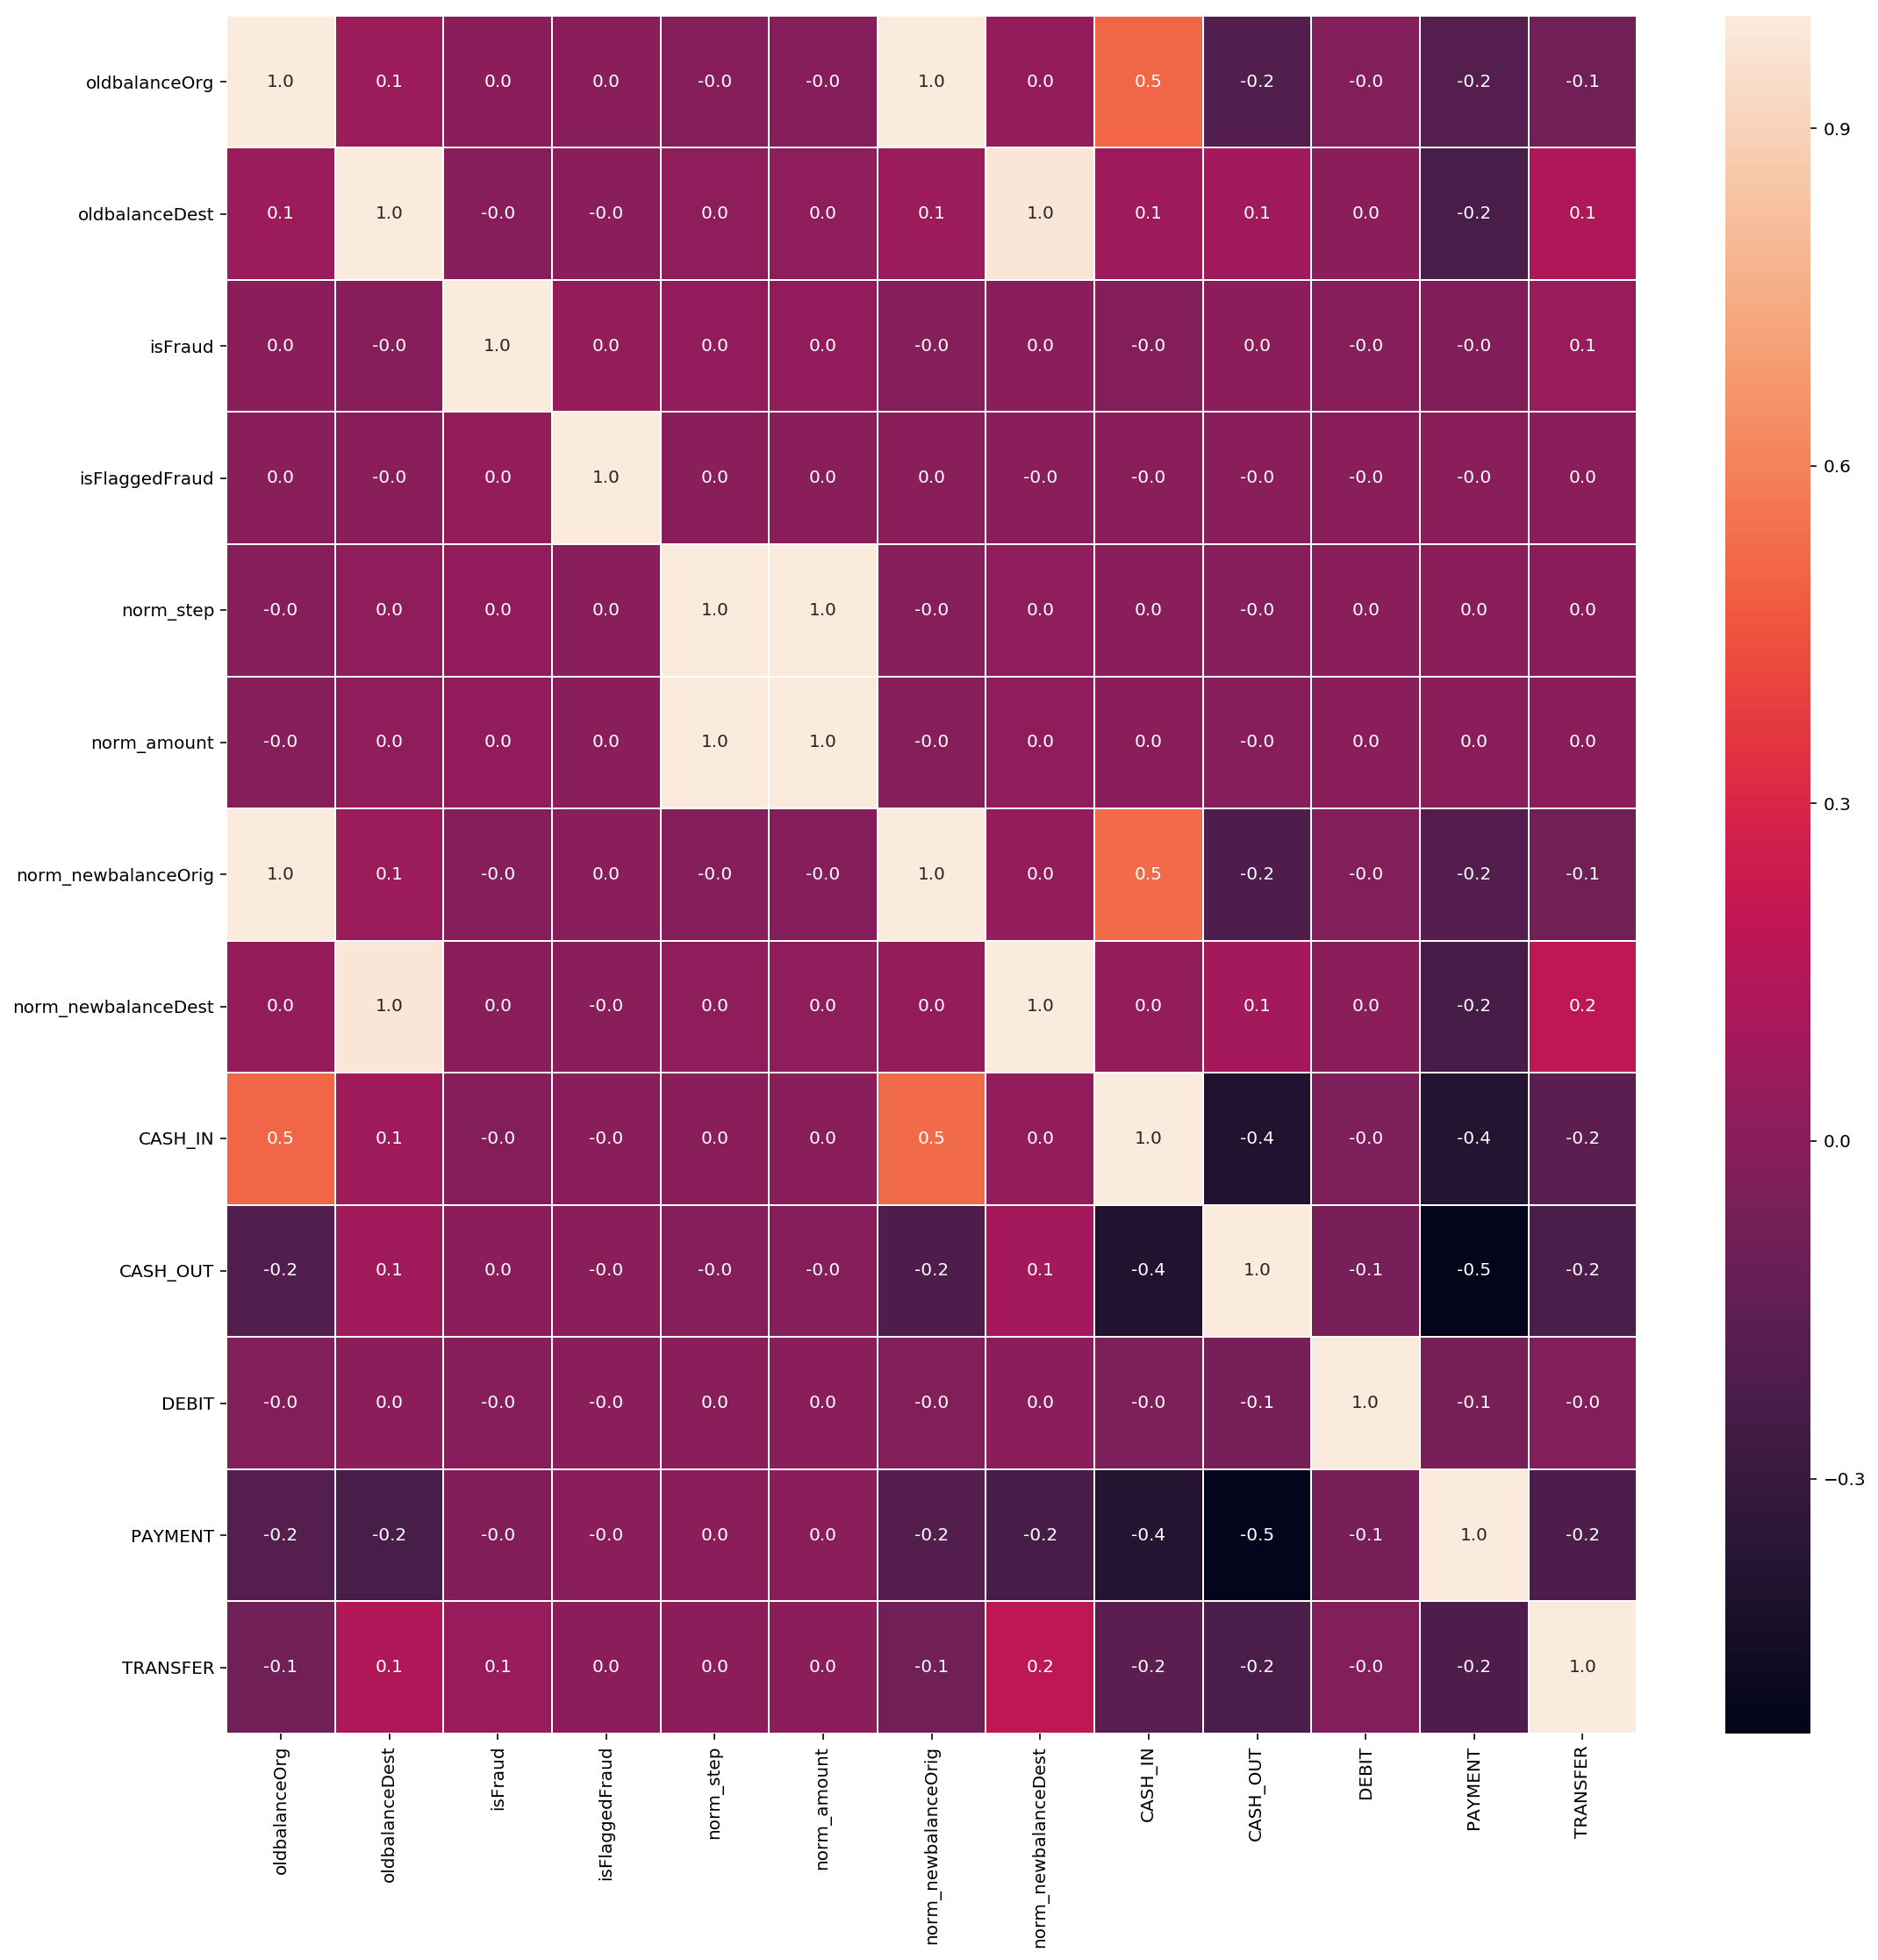

In [17]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

## Prepare the data for training

In [18]:
#randomize the data to be sure not to have any pathological ordering effects that might impact on gradient descent.
data = data.reindex(
    np.random.permutation(data.index))

In [19]:
#pickle.dump(data, open( "processed_data.pkl", "wb" ))

In [20]:
#data = pickle.load(open( "processed_data.pkl", "rb" ))

In [21]:
from imblearn.over_sampling import ADASYN#SMOTE
sm = ADASYN(n_jobs=-1)

In [22]:
# split the features and target vector for resampling
X = data.loc[:, data.columns != 'isFraud']
y = data.loc[:, data.columns == 'isFraud']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [24]:
#resmaple just the training data and leave the test data untouched
tic()
#X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)
toc()
# this step takes a bit of time so I pickle the output

Elapsed time is 3.504753112792969e-05 seconds.


In [25]:
#pickle.dump(X_train_resampled, open( "X_train_resampled.pkl", "wb" ))
#pickle.dump(y_train_resampled, open( "y_train_resampled.pkl", "wb" ))

In [26]:
X_train_resampled = pickle.load(open( "X_train_resampled.pkl", "rb" ))
y_train_resampled = pickle.load(open( "y_train_resampled.pkl", "rb" ))

### Visualize the resampling

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

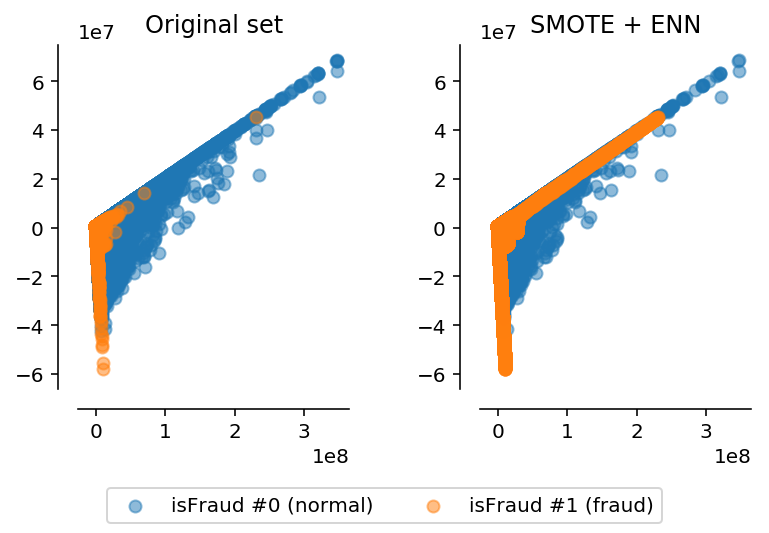

In [35]:
X_res_vis = pca.transform(X_train_resampled)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y['isFraud'] == 0, 0], X_vis[y['isFraud'] == 0, 1], label="isFraud #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y['isFraud'] == 1, 0], X_vis[y['isFraud'] == 1, 1], label="isFraud #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_train_resampled == 0, 0], X_res_vis[y_train_resampled == 0, 1],
            label="isFraud #0", alpha=0.5)
ax2.scatter(X_res_vis[y_train_resampled == 1, 0], X_res_vis[y_train_resampled == 1, 1],
            label="isFraud #1", alpha=0.5)
ax2.set_title('SMOTE + ENN')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    #ax.set_xlim([-10, 10])
    #ax.set_ylim([-10, 10])

f.legend((c0, c1), ('isFraud #0 (normal)', 'isFraud #1 (fraud)'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

## Machine learning

In [27]:
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.externals import joblib #for saving the trained model

In [28]:
# confusion matrix plotting function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Feature selection

In [32]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# Create the RFE object and rank each pixel
clf_rf = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train_resampled[0:1000000], y_train_resampled[0:1000000])
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['oldbalanceOrg', 'norm_step', 'norm_amount', 'norm_newbalanceOrig',
       'norm_newbalanceDest'],
      dtype='object')


Text(0,0.5,'explained_variance_ratio_')

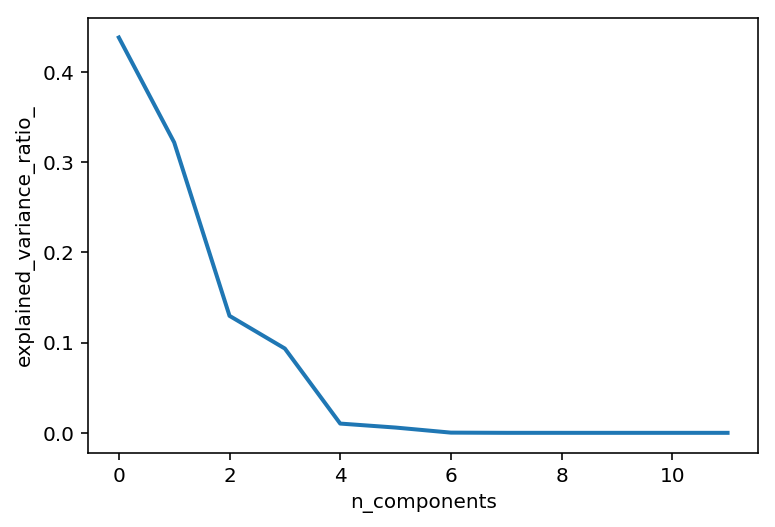

In [69]:
from sklearn.decomposition import PCA
#normalization
xtrain_norm = (X_train-X_train.mean())/(X_train.max()-X_train.min())
xtest_norm = (X_test-X_test.mean())/(X_test.max()-X_test.min())

pca = PCA(n_components=12) # set number of components to plot table below
pca.fit(xtrain_norm)

plt.figure()
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [97]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_2 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_2, step=1, cv=10,scoring='accuracy')   #10-fold cross-validation
rfecv = rfecv.fit(X_train_resampled[0:100000], y_train_resampled[0:100000])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['oldbalanceOrg', 'oldbalanceDest', 'norm_step', 'norm_amount',
       'norm_newbalanceOrig', 'norm_newbalanceDest', 'CASH_IN', 'CASH_OUT',
       'DEBIT', 'PAYMENT', 'TRANSFER'],
      dtype='object')


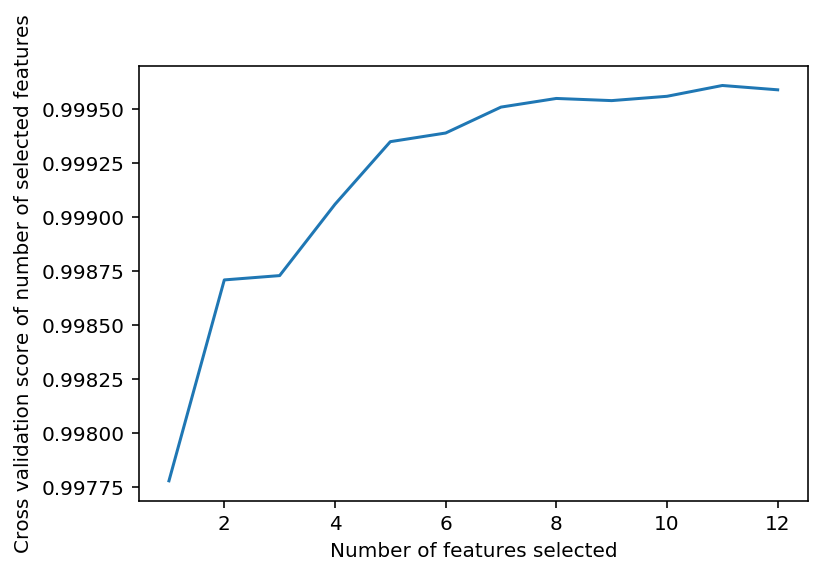

In [98]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
# everything looks useful in this dataset

### Logistic regression

In [38]:
# try a grid search to find best parameters
from sklearn.model_selection import GridSearchCV
tic()
lr = LogisticRegression(C = 0.01, penalty = 'l1')# , solver='liblinear')
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}#[0.001,0.01,0.1,1,10,100]}
lr = GridSearchCV(lr, param_grid=grid_values, n_jobs=-1)
lr.fit(X_train_resampled,y_train_resampled)
print(lr.best_params_)

y_pred = lr.predict(X_test)
toc()

# Result: 0.97 with gridsearch finding l2 penalty and C=0.01.

{'C': 100, 'penalty': 'l1'}
Elapsed time is 1995.3649451732635 seconds.


Recall metric in the testing dataset:  0.9339080459770115


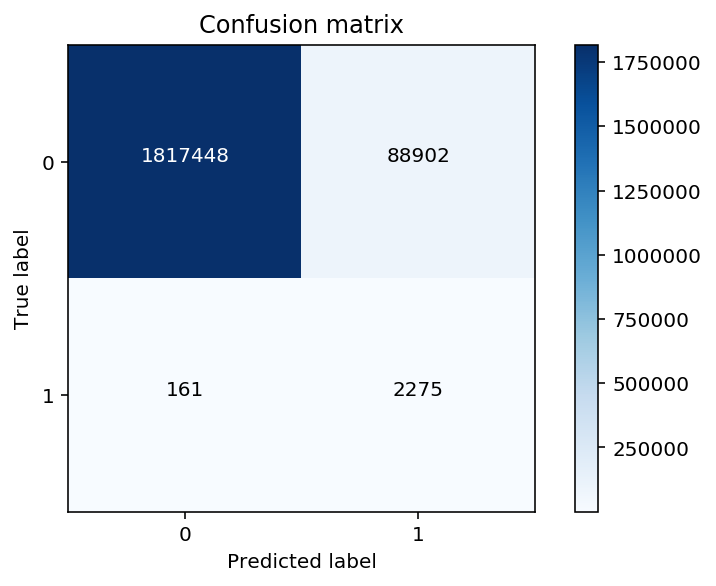

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [40]:
#save the model
#joblib.dump(lr, 'lr_model.pkl')

['lr_model.pkl']

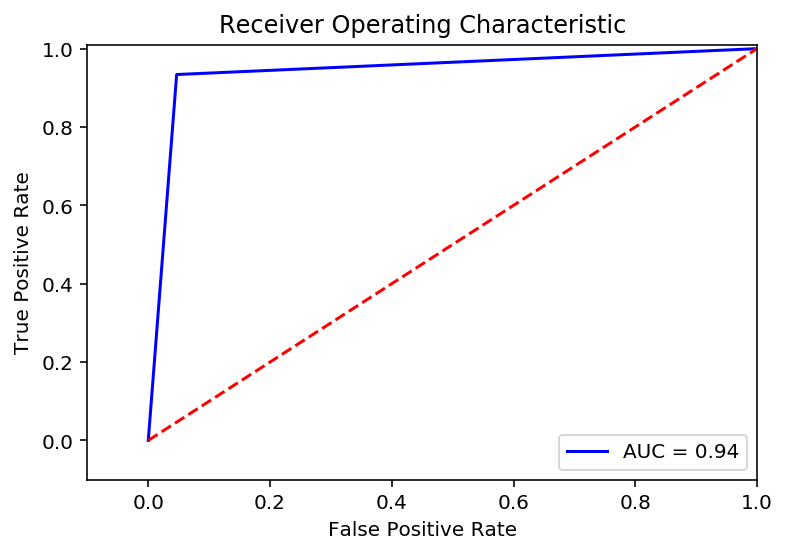

In [43]:
# ROC curve
lr = LogisticRegression(C = 100, penalty = 'l1')
y_pred_score = lr.fit(X_train_resampled,y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Not too bad, can we do better?

### Stochastic Gradient Descent

* http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4

In [63]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

In [102]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 103.9min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 180.5min remaining: 82.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 228.2min remaining: 52.7min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 237.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    4.3s finished


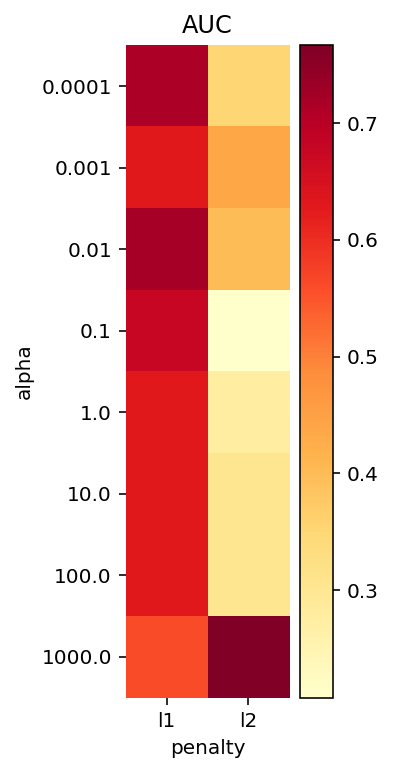

SGDClassifier(alpha=1000.0, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=8418,
       shuffle=True, tol=None, verbose=0, warm_start=False) 0.7666844752611538


In [110]:
# hyper parameter tuning with parfit

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],  # learning rate
    'n_iter': [1000],  # number of epochs
    'loss': ['log'],  # logistic regression,
    'penalty': ['l1', 'l2'],
    'n_jobs': [-1],
    'random_state': [8418]
}
paramGrid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(
    SGDClassifier(),
    paramGrid,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,  # nfolds=5 [optional, instead of validation set]
    metric=roc_auc_score,
    greater_is_better=True,
    scoreLabel='AUC')

print(best_model, best_score)

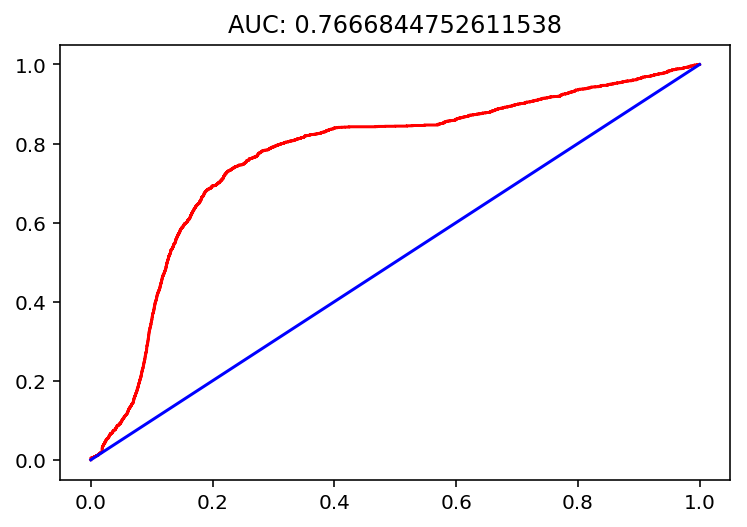

In [111]:
plot_roc_auc(y_test, best_model.predict_proba(X_test))

In [112]:
tic()

sgd = SGDClassifier(
    alpha=1000.0,
    average=False,
    class_weight=None,
    epsilon=0.1,
    eta0=0.0,
    fit_intercept=True,
    l1_ratio=0.15,
    learning_rate='optimal',
    loss='log',
    max_iter=1000,  #set this to 1000 for a full run
    n_jobs=-1,
    penalty='l2',
    power_t=0.5,
    random_state=8418,
    shuffle=True,
    tol=None,
    verbose=0,
    warm_start=False)

#grid_values = {'penalty': ['l1','l2', 'elasticnet'], 'alpha': [0.000001, 0.001,0.01,1], 'epsilon': [0.01,0.1,1]}

# grid search to find the best number of estimators
#sgd = GridSearchCV(sgd, param_grid=grid_values, n_jobs=-1)

sgd.fit(X_train_resampled, y_train_resampled)

y_pred = sgd.predict(X_test)

toc()

ac = accuracy_score(y_test,sgd.predict(X_test))
print('Accuracy is: ',ac)
#print('model accuracy =',sgd.score(X_test, y_test)*100,'%')

Elapsed time is 2871.5356669425964 seconds.
Accuracy is:  0.3012941209753215


In [113]:
#save the model
joblib.dump(sgd, 'sgd_model.pkl')

['sgd_model.pkl']

Recall metric in the testing dataset:  0.8985971943887776


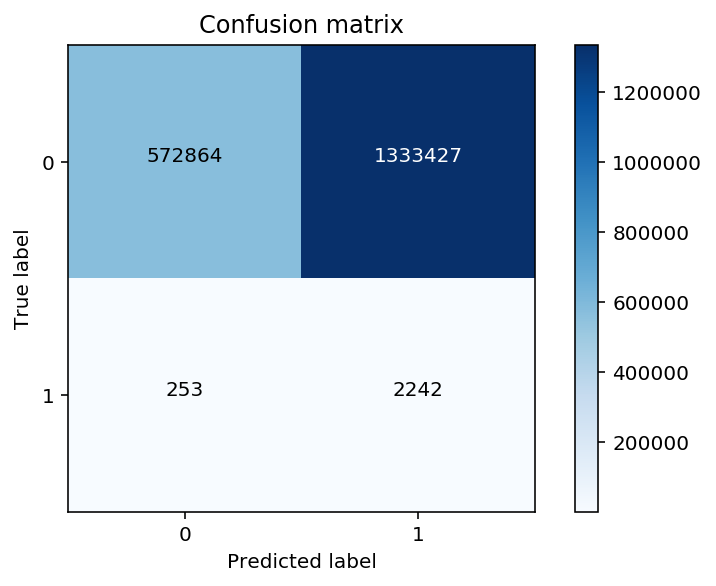

In [114]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ",
      cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

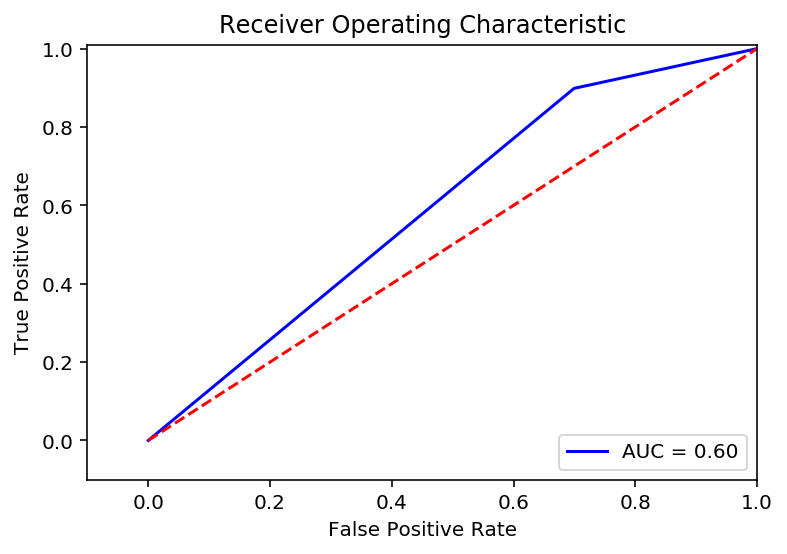

In [115]:
# ROC curve
y_pred_score = sgd.fit(X_train_resampled,y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This is a terrible model using SGD

### Support vector machine

In [26]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA(n_components=12, random_state=8418, svd_solver='randomized')
svc = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced'), n_jobs=-1)
model = make_pipeline(pca,svc)

In [ ]:
tic()
svm_model = model.fit(X_train_resampled, y_train_resampled)
toc()

In [ ]:
ac = accuracy_score(y_test,svm_model.predict(X_test))
print('Accuracy is: ',ac)